In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns; sns.set()
sns.set_context('poster'); plt.style.use('fivethirtyeight')

from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier

# Topic modeling imports
from nltk.stem import SnowballStemmer
from nltk.tokenize import TreebankWordTokenizer, sent_tokenize, word_tokenize
from gensim import models, corpora
import string

# Note -- on command line, ran `2to3 -wn textstat.py` in anaconda directory to convert print statements over to Python
# 3 format; see https://docs.python.org/2/library/2to3.html
from textstat.textstat import textstat

In [3]:
def percentify_y():
    plt.gca().yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f%%'))
    
def percentify_x():
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f%%'))
    
def output_figure(filename):
    """
    Save the most recently generated chart as a png with the filename passed as an argument
    """
    plt.tight_layout()
    plt.savefig('./charts/' + filename + '.png', dpi=200)

In [4]:
# Downloaded CSV for all complaints with a narrative (i.e., text explanation) from 
# http://www.consumerfinance.gov/complaintdatabase/

df = pd.read_csv('raw/Consumer_Complaints_with_Consumer_Complaint_Narratives.csv', index_col='Complaint ID')

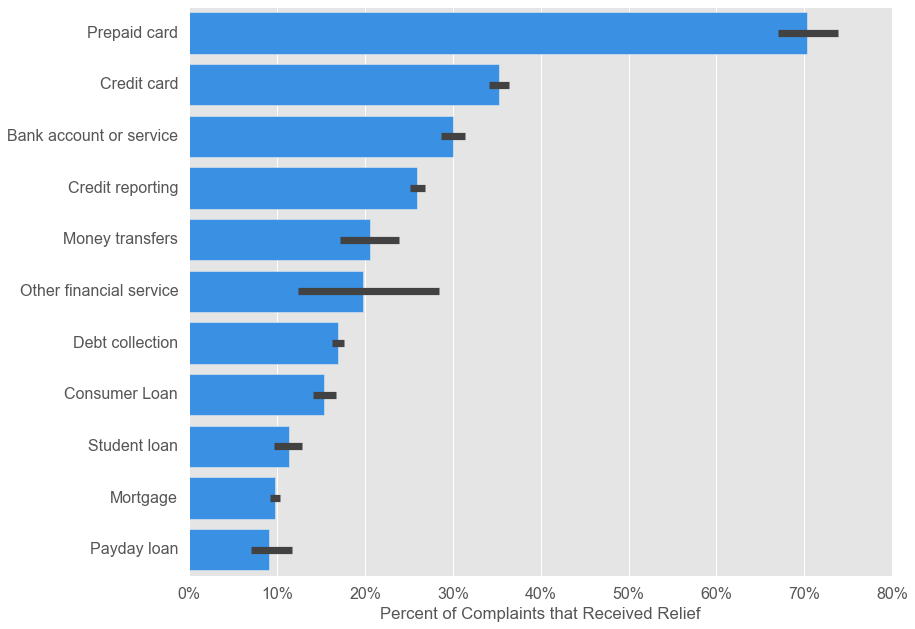

In [5]:
df['Relief Indicator'] = [x in {'Closed with non-monetary relief', 'Closed with monetary relief'} for x in df['Company response to consumer']]

products_sorted_by_relief_perc = df.groupby('Product')['Relief Indicator'].mean().sort_values(ascending=False).index

with plt.style.context('ggplot'):
    sns.barplot(y=df['Product'], x=(100*df['Relief Indicator']),order=products_sorted_by_relief_perc, color='DodgerBlue')
    plt.ylabel('')
    plt.xlabel('Percent of Complaints that Received Relief')
    percentify_x()
    output_figure('financial_products_vs_likelihood_of_relief')

In [93]:
# Redo analysis without high-xxxx complaints
credit_card_df_wo_high_xxxx = credit_card_df.copy()

complaints_wo_high_xxxx = credit_card_df_wo_high_xxxx['Consumer complaint narrative'].values

vect_wo_high_xxxx = CountVectorizer(ngram_range=(1,3), stop_words='english')

X_words_wo_high_xxxx = vect_wo_high_xxxx.fit_transform(complaints_wo_high_xxxx)
words_wo_high_xxxx = vect_wo_high_xxxx.get_feature_names()

y_wo_high_xxxx = [int(x) for x in credit_card_df_wo_high_xxxx['Relief Indicator'].values]

clf_wo_high_xxxx = MultinomialNB(alpha=0)
clf_wo_high_xxxx.fit(X_words_wo_high_xxxx,y_wo_high_xxxx)

likelihood_df_wo_high_xxxx = pd.DataFrame(clf_wo_high_xxxx.feature_log_prob_.transpose(),
                                          columns=['NoRelief', 'Relief'], index=words_wo_high_xxxx)

likelihood_df_wo_high_xxxx['Percent More Likely to Get Relief'] = likelihood_df_wo_high_xxxx.eval('100 * (exp(Relief) - exp(NoRelief))')
bottom_15_wo_high_xxxx = likelihood_df_wo_high_xxxx['Percent More Likely to Get Relief'].sort_values(ascending=False)

bottom_15_wo_high_xxxx

xxxx                0.253713
00                  0.169503
fee                 0.116476
late                0.094725
xxxx xxxx           0.092236
charge              0.083260
payment             0.075891
statement           0.067610
charged             0.059418
fees                0.057479
macy                0.055109
told                0.053722
late fee            0.051420
paid                0.051325
xx                  0.049187
charges             0.047567
received            0.047396
called              0.043691
2015                0.040560
balance             0.039702
xxxx 2015           0.039453
did                 0.039402
bank                0.037995
xxxx xxxx 2015      0.034284
late fees           0.033486
service             0.028709
xx xx xxxx          0.025566
phone               0.025419
xx xx               0.024685
xxxx 15             0.024170
                      ...   
credit line        -0.014074
credit cards       -0.014841
does               -0.014898
car           

In [74]:
bottom_15_series

xxxx             -0.235443
credit           -0.194954
card             -0.116313
xxxx xxxx        -0.072691
account          -0.065194
chase            -0.057405
credit card      -0.055899
xxxx xxxx xxxx   -0.038431
capital          -0.037181
report           -0.035914
information      -0.031938
years            -0.026670
cards            -0.025981
time             -0.025579
debt             -0.025268
Name: Percent More Likely to Get Relief, dtype: float64

In [6]:
# Use Naive Bayes to predict whether a complaint about credit cards will receive relief (given the complaint text)

credit_card_df = df[df['Product'] == 'Credit card'].copy()
complaints = credit_card_df['Consumer complaint narrative'].values

In [7]:
vect = CountVectorizer(ngram_range=(1,3), stop_words='english')
X_words = vect.fit_transform(complaints)
words = vect.get_feature_names()

In [8]:
y = [int(x) for x in credit_card_df['Relief Indicator'].values]

In [9]:
clf = MultinomialNB()
clf.fit(X_words,y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

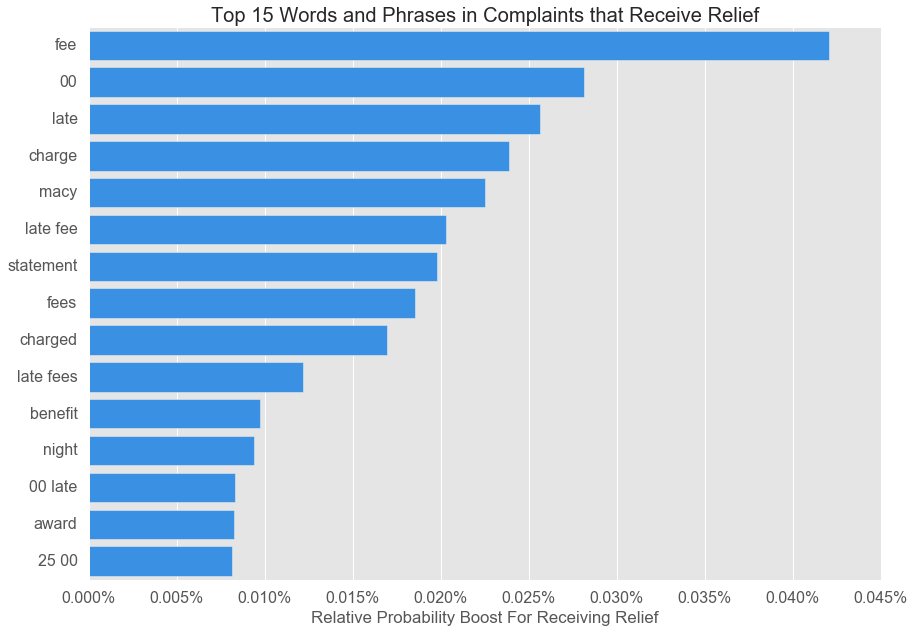

In [10]:
likelihood_df = pd.DataFrame(clf.feature_log_prob_.transpose(),columns=['NoRelief', 'Relief'], index=words)

# Undo log of probabilities and take difference to look at relative probability differences
likelihood_df['Percent More Likely to Get Relief'] = likelihood_df.eval('100 * (exp(Relief) - exp(NoRelief))')
top_15_series = likelihood_df['Percent More Likely to Get Relief'].sort_values(ascending=False).ix[:15]

with plt.style.context('ggplot'):
    sns.barplot(y=top_15_series.index, x=top_15_series, color='DodgerBlue')
    plt.ylabel('')
    plt.xlabel('Relative Probability Boost For Receiving Relief')
    plt.title('Top 15 Words and Phrases in Complaints that Receive Relief')
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f%%'))
    output_figure('top_15_words')

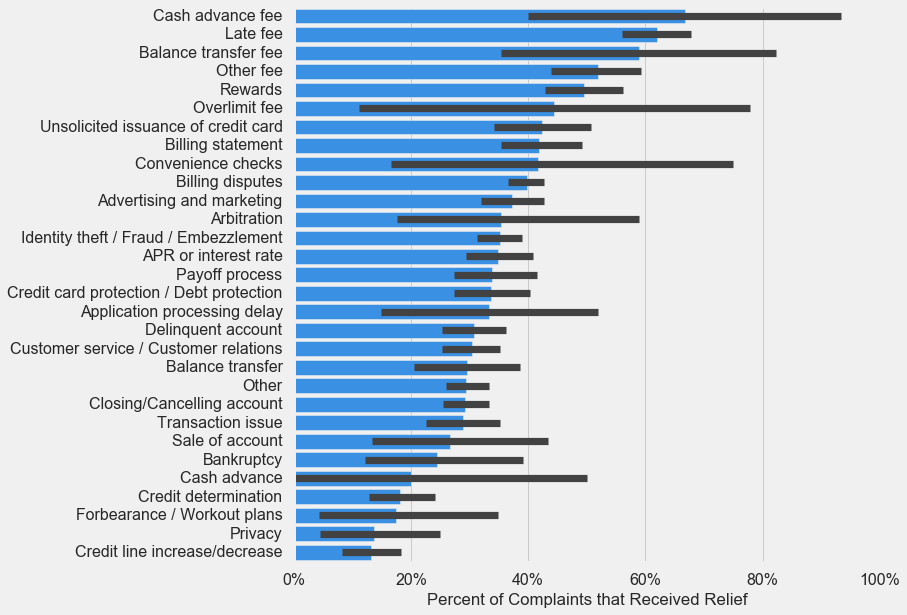

In [11]:
#Exploring late fees

relief_by_issue_sort_order = credit_card_df.groupby('Issue')['Relief Indicator'].mean().sort_values(ascending=False).index

with plt.style.context('fivethirtyeight'):
    sns.barplot(y=credit_card_df['Issue'],x=100*credit_card_df['Relief Indicator'], color='DodgerBlue',
               order=relief_by_issue_sort_order)
    plt.ylabel('')
    plt.xlabel('Percent of Complaints that Received Relief')
    percentify_x()
    output_figure('credit_card_issues_vs_likelihood_of_relief')

In [12]:
fee_issues = {x for x in credit_card_df["Issue"].value_counts().index if 'fee' in x}
credit_card_df['Fee Issue Indicator'] = [x in fee_issues for x in credit_card_df['Issue']]
credit_card_df['Fee Text Indicator'] = ['fee' in y for y in [x.lower() for x in complaints]]

cc_companies_series = (credit_card_df.groupby('Company').count().iloc[:,0] > 25)
cc_large_companies = cc_companies_series[cc_companies_series==True]
cc_large_companies_bool = [x in cc_large_companies for x in credit_card_df['Company']]
lc_credit_card_df = credit_card_df.loc[cc_large_companies_bool,:].copy()

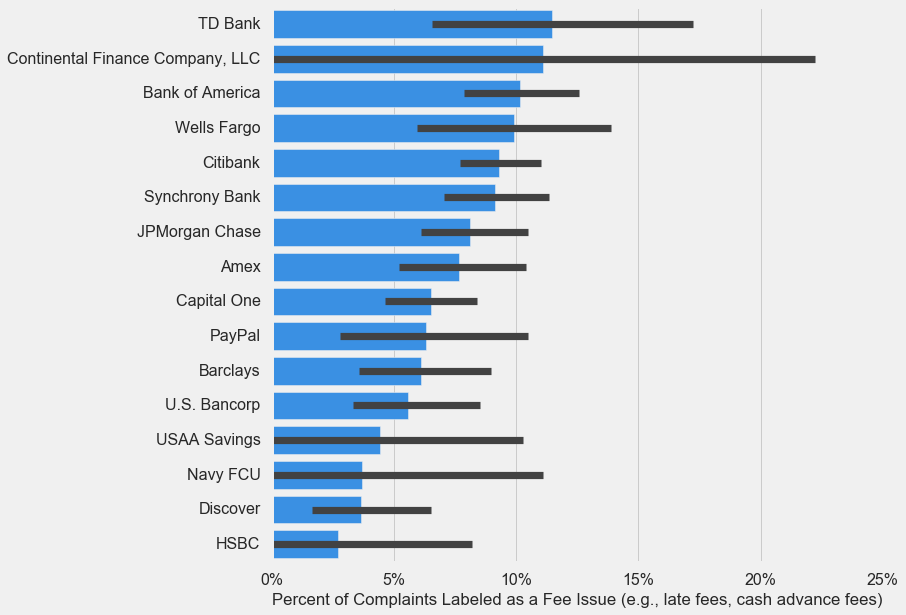

In [13]:
company_fee_issue_sort_order = lc_credit_card_df.groupby('Company')['Fee Issue Indicator'].mean().sort_values(ascending=False).index

with plt.style.context('fivethirtyeight'):
    sns.barplot(y=lc_credit_card_df['Company'],x=100*lc_credit_card_df['Fee Issue Indicator'], color='DodgerBlue',
               order=company_fee_issue_sort_order)
    plt.ylabel('')
    plt.xlabel('Percent of Complaints Labeled as a Fee Issue (e.g., late fees, cash advance fees)')
    percentify_x()
    output_figure('proportion_of_fee_issues_by_company')

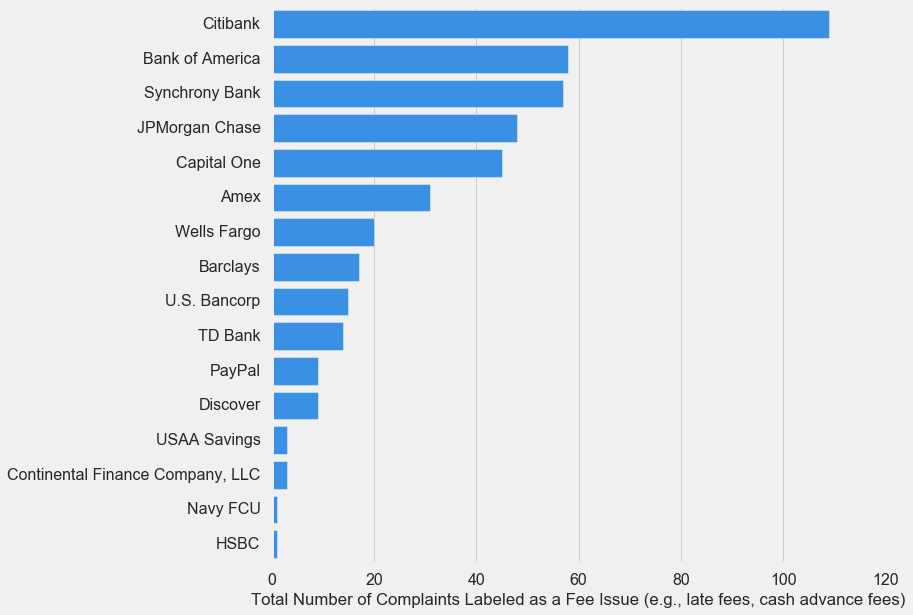

In [14]:
# Maybe note the naive way to do this as a cautionary tale -- but this kind of punts the denominator issue over to
# the total # of complaints

cc_countplot_sort_order = lc_credit_card_df.loc[lc_credit_card_df['Fee Issue Indicator']==True].groupby('Company').count().iloc[:,0].sort_values(ascending=False).index

with plt.style.context('fivethirtyeight'):
    sns.countplot(y=lc_credit_card_df.loc[lc_credit_card_df['Fee Issue Indicator']==True,'Company'],
                 color='DodgerBlue', order=cc_countplot_sort_order)
    plt.xlabel('Total Number of Complaints Labeled as a Fee Issue (e.g., late fees, cash advance fees)')
    plt.ylabel('')
    output_figure('count_of_fee_issues_by_company')

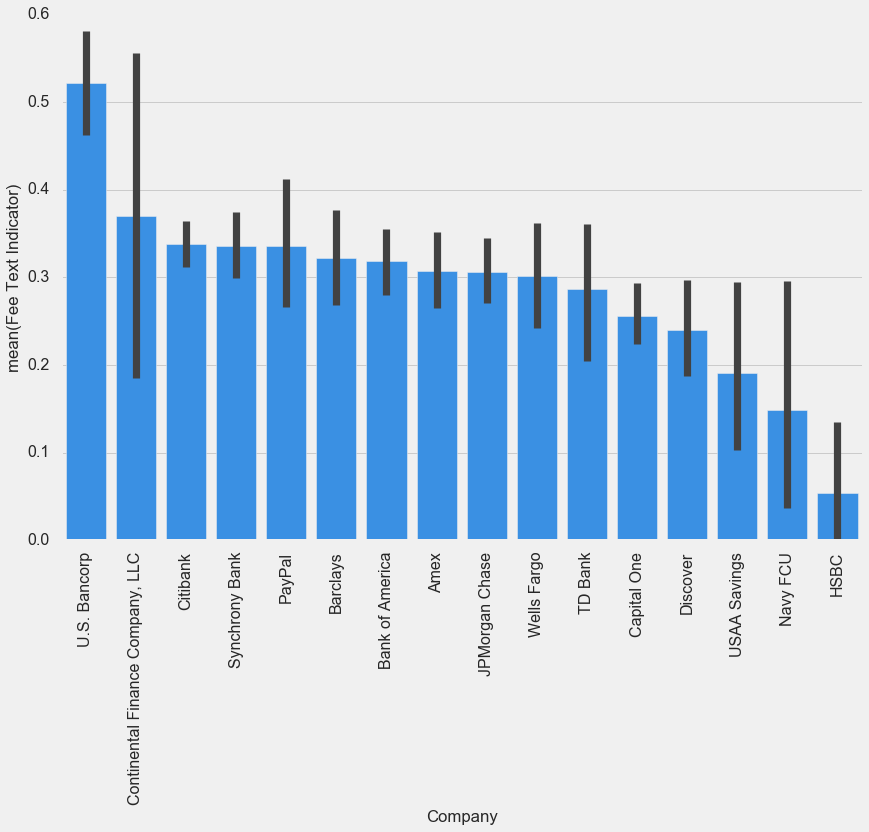

In [15]:
# Unused, but an interesting aside about the different things "fee" can mean

company_fee_issue_sort_order = lc_credit_card_df.groupby('Company')['Fee Text Indicator'].mean().sort_values(ascending=False).index

with plt.style.context('fivethirtyeight'):
    sns.barplot(x=lc_credit_card_df['Company'],y=lc_credit_card_df['Fee Text Indicator'], color='DodgerBlue',
               order=company_fee_issue_sort_order)
    plt.xticks(rotation='vertical')

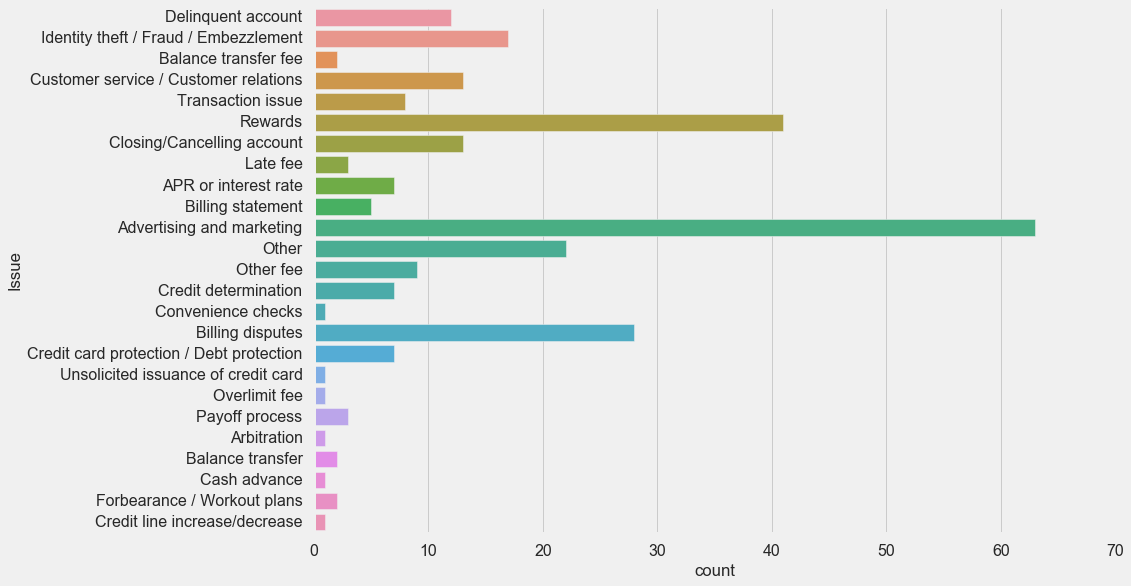

In [16]:
# Unused, but an interesting aside about the different things "fee" can mean

sns.countplot(y=credit_card_df.loc[(credit_card_df['Company'] == 'U.S. Bancorp'),'Issue'])

In [17]:
# Uncomment to see how the "fees" come up for U.S. Bancorp because they have an annual fee card with rewards cards

#credit_card_df.query('Issue == "Advertising and marketing" and Company == "U.S. Bancorp"')['Consumer complaint narrative'].values

In [18]:
credit_card_df['Twenty Five Indicator'] = ['25' in x for x in complaints]
credit_card_df.groupby('Twenty Five Indicator')['Relief Indicator'].mean()

Twenty Five Indicator
False    0.344752
True     0.470414
Name: Relief Indicator, dtype: float64

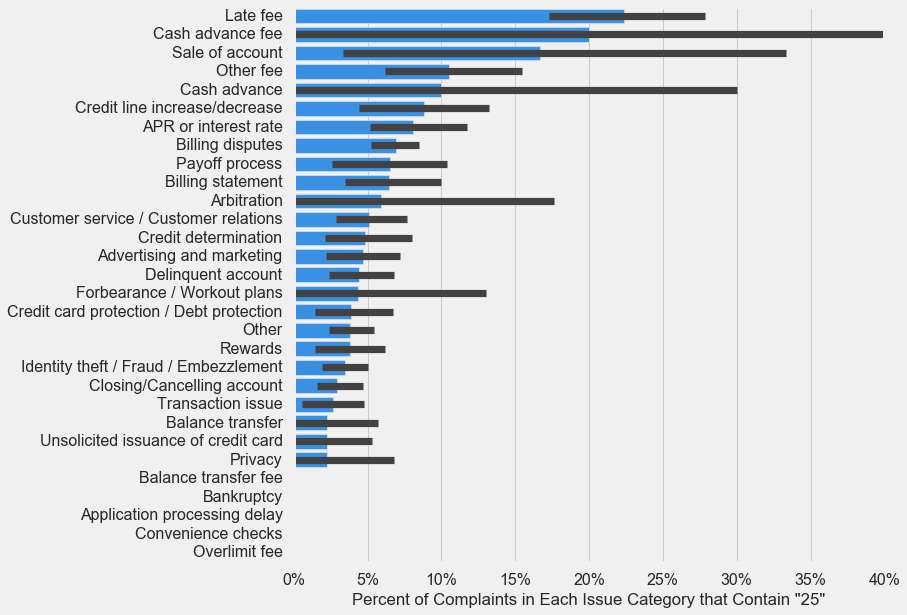

In [19]:
twenty_five_sort_order = credit_card_df.groupby('Issue')['Twenty Five Indicator'].mean().sort_values(ascending=False).index
with plt.style.context('fivethirtyeight'):
    sns.barplot(y=credit_card_df['Issue'],x=100*credit_card_df['Twenty Five Indicator'], color="DodgerBlue",
               order=twenty_five_sort_order)
    plt.ylabel('')
    percentify_x()
    plt.xlabel('Percent of Complaints in Each Issue Category that Contain "25"')
    output_figure('perc_complaints_contain_25')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

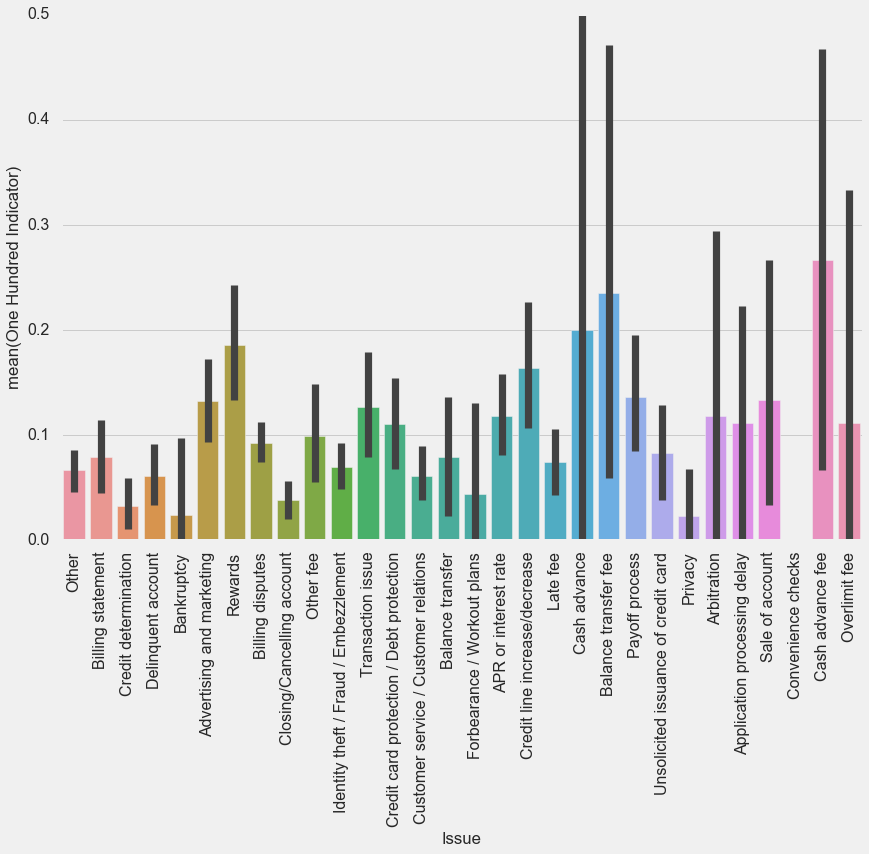

In [20]:
#Unused, but also interesting to note since 100 was in the ~top 25

credit_card_df['One Hundred Indicator'] = ['100' in x for x in complaints]

sns.barplot(x=credit_card_df['Issue'],y=credit_card_df['One Hundred Indicator'])
plt.xticks(rotation='vertical')

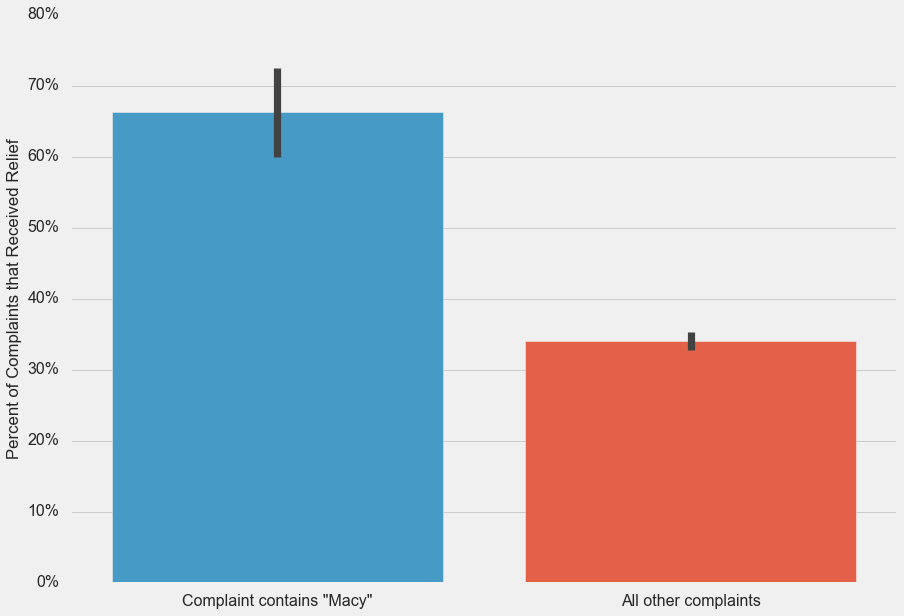

In [21]:
# Exploring Macy's finding

macys_df = credit_card_df.loc[['macy' in y for y in [x.lower() for x in complaints]],:]

macys_bool =['macy' in y for y in [x.lower() for x in complaints]]
#Choosing labels to make a nice bar chart
credit_card_df["Macys Indicator"] = ['Complaint contains "Macy"' if x==True else 'All other complaints' for x in macys_bool]

with plt.style.context('fivethirtyeight'):    
    sns.barplot(x='Macys Indicator', y=100*credit_card_df['Relief Indicator'], data=credit_card_df,
                order=['Complaint contains "Macy"', 'All other complaints'])
    plt.xlabel('')
    percentify_y()
    plt.ylabel('Percent of Complaints that Received Relief')
    output_figure('perc_relief_macys_versus_rest')

In [22]:
macys_df['Company'].value_counts()

Citibank          220
JPMorgan Chase      2
Navy FCU            1
Amex                1
Capital One         1
Name: Company, dtype: int64

In [25]:
#Worst 15 Words

bottom_15_series = likelihood_df['Percent More Likely to Get Relief'].sort_values().ix[:15]

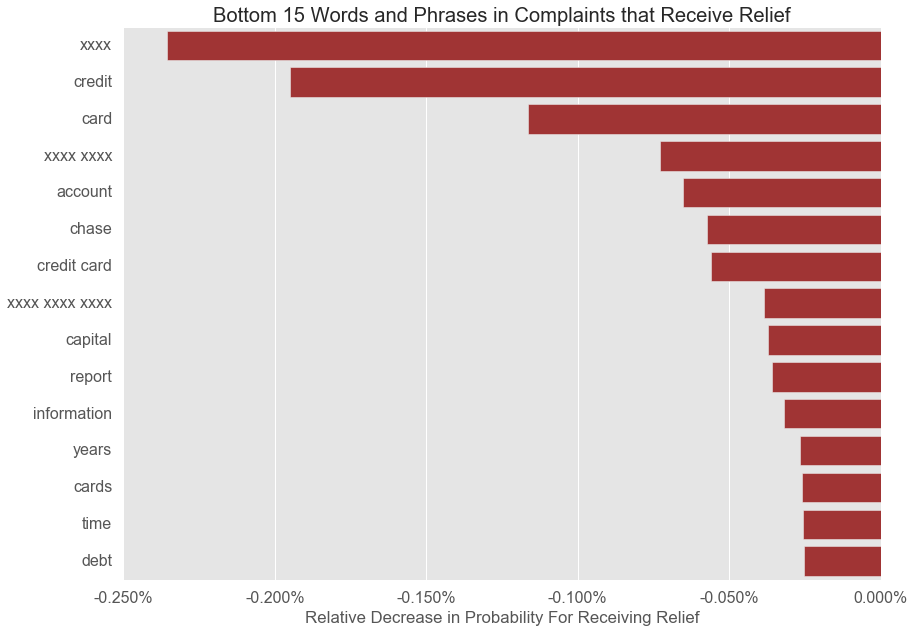

In [38]:
with plt.style.context('ggplot'):
    sns.barplot(y=bottom_15_series.index, x=bottom_15_series, color='FireBrick')
    plt.ylabel('')
    plt.xlabel('Relative Decrease in Probability For Receiving Relief')
    plt.title('Bottom 15 Words and Phrases in Complaints that Receive Relief')
    plt.gca().xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f%%'))
    output_figure('bottom_15_words')

In [39]:
# Information that needs to be scrubbed

In [59]:
credit_card_df['xxxx_count'] = [3*(x.lower().count('xxxx')//3) for x in complaints]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text xticklabel objects>)

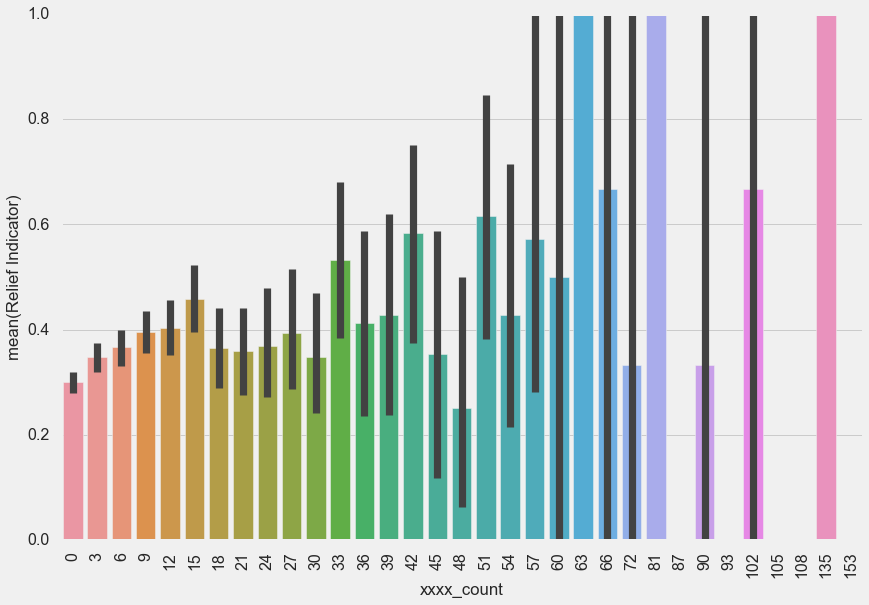

In [60]:
sns.barplot(x=credit_card_df['xxxx_count'], y=credit_card_df['Relief Indicator'])
plt.xticks(rotation='vertical')

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

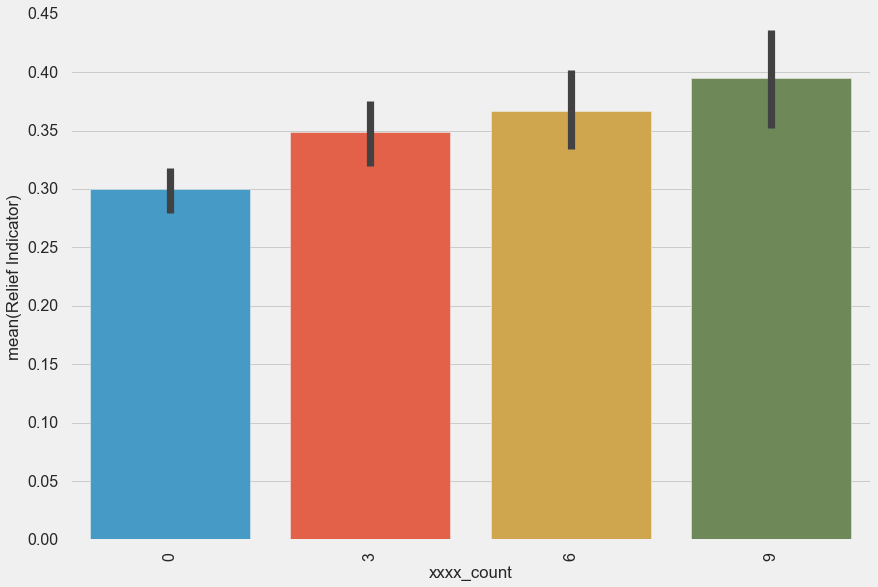

In [80]:
sns.barplot(x=credit_card_df_wo_high_xxxx['xxxx_count'], y=credit_card_df_wo_high_xxxx['Relief Indicator'])
plt.xticks(rotation='vertical')

In [88]:
bottom_15_wo_high_xxxx[['xx' in x for x in bottom_15_wo_high_xxxx.index]]

bank xxxx             0.003950
bank xxxx xxxx        0.003526
xxxx months           0.003060
fee xxxx              0.002343
xxxx xxxx 2015        0.002162
00 xxxx xxxx          0.002158
xxxx late             0.002085
xxxx free             0.001904
xxxx night            0.001868
xxxx minutes          0.001768
xxxx 2015             0.001601
xxxx times day        0.001587
charged xxxx          0.001487
xxxx late fees        0.001440
xxxx xxxx visa        0.001428
xxxx bonus points     0.001330
xxxx balance          0.001326
xxxx received         0.001302
refund xxxx           0.001221
macy xxxx             0.001221
paid xxxx xxxx        0.001220
xxxx late fee         0.001196
xxxx billing          0.001183
late fee xxxx         0.001159
id xxxx               0.001147
told xxxx             0.001145
xxxx charged          0.001109
xxxx points           0.001094
xxxx free night       0.001086
xxxx charge           0.001061
                        ...   
xx xx 2015           -0.001778
xxxx 201

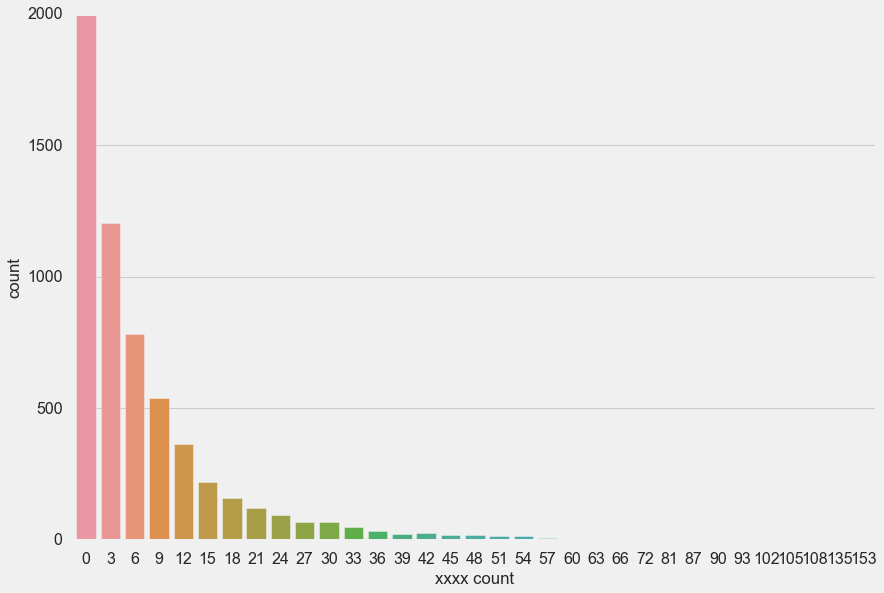

In [49]:
sns.countplot(credit_card_df['xxxx count'])

In [ ]:
credit_card_df

In [22]:
# STOPPED REFACTORING HERE

In [23]:
# Checking rambling hypothesis

naive_bayes_df['char_count'] = [len(x) for x in complaints]
naive_bayes_df['smog'] = [textstat.smog_index(x) for x in complaints]
naive_bayes_df['difficult_words'] = [textstat.difficult_words(x) for x in complaints]

# Sentences need to have at least three words, so pasting on "Pizza" to make two entries of "Identity theft" work
# Pizza House! -- https://www.youtube.com/watch?v=_Iw0euc4qDk 
naive_bayes_df['readability'] = [textstat.automated_readability_index('Pizza ' + x) for x in complaints]
naive_bayes_df['lexicon_count'] = [textstat.lexicon_count(x) for x in complaints]
naive_bayes_df['syllable_count'] = [textstat.syllable_count(x) for x in complaints]
naive_bayes_df['sentence_count'] = [textstat.sentence_count('Pizza ' + x) for x in complaints]
#Add period to prevent "zero sentence" for people that typed "Identity theft" only
#Some have zero sentences, annoyingly (no punctuation)
naive_bayes_df['words_per_sentence'] = naive_bayes_df['lexicon_count']/naive_bayes_df['sentence_count']
naive_bayes_df['syllable_per_word'] = naive_bayes_df['syllable_count']/naive_bayes_df['lexicon_count']

naive_bayes_df.groupby('Company response to consumer').mean()

NameError: name 'naive_bayes_df' is not defined

In [ ]:
# Ranking companies by reading level of their complaints = interesting (AmEx does particularly well, perhaps
# unsurprisingly)

# Doing same thing with issues would be cool too

#Use Seaborn plots here to automatically get the uncertainty in there

#naive_bayes_df[large_companies_bool].groupby('Company').mean().sort_values(by='smog')

In [ ]:
sns.countplot(hue=naive_bayes_df['Company response to consumer'], x=naive_bayes_df['Issue'])
plt.xticks(rotation='vertical')

In [ ]:
naive_bayes_df

In [ ]:
temp = pd.DataFrame(naive_bayes_df.groupby(['Company']).count().iloc[:,0]).reset_index()

large_companies = temp[temp['Date received'] > 100]['Company'].values

large_companies_bool = [x in large_companies for x in naive_bayes_df['Company']]

In [ ]:
# Better if just plot as one, i.e., empirical likelihood of closing with monetary relief, descending for companies

with plt.style.context('fivethirtyeight'):
    sns.countplot(hue=naive_bayes_df.loc[large_companies_bool,'Company response to consumer'], x=naive_bayes_df.loc[large_companies_bool,'Company'])
    plt.xticks(rotation='vertical')

In [ ]:
# Wrapper from https://gist.github.com/slaypni/b95cb69fd1c82ca4c2ff

import sys
import math

import numpy as np

sys.path.append('xgboost/wrapper/')
import xgboost as xgb


class XGBoostClassifier():
    def __init__(self, num_boost_round=10, **params):
        self.clf = None
        self.num_boost_round = num_boost_round
        self.params = params
        self.params.update({'objective': 'multi:softprob'})

    def fit(self, X, y, num_boost_round=None):
        num_boost_round = num_boost_round or self.num_boost_round
        self.label2num = dict((label, i) for i, label in enumerate(sorted(set(y))))
        dtrain = xgb.DMatrix(X, label=[self.label2num[label] for label in y])
        self.clf = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=num_boost_round)

    def predict(self, X):
        num2label = dict((i, label)for label, i in self.label2num.items())
        Y = self.predict_proba(X)
        y = np.argmax(Y, axis=1)
        return np.array([num2label[i] for i in y])

    def predict_proba(self, X):
        dtest = xgb.DMatrix(X)
        return self.clf.predict(dtest)

    def score(self, X, y):
        Y = self.predict_proba(X)
        return 1 / logloss(y, Y)

    def get_params(self, deep=True):
        return self.params

    def set_params(self, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        if 'objective' in params:
            del params['objective']
        self.params.update(params)
        return self
    
    
def logloss(y_true, Y_pred):
    label2num = dict((name, i) for i, name in enumerate(sorted(set(y_true))))
    return -1 * sum(math.log(y[label2num[label]]) if y[label2num[label]] > 0 else -np.inf for y, label in zip(Y_pred, y_true)) / len(Y_pred)

In [ ]:
clf = XGBoostClassifier(num_class=2)

In [ ]:
predictive_colz = ['Issue','Company','char_count','word_count']

In [ ]:
xgb_df = naive_bayes_df[predictive_colz].copy()

In [ ]:
xgb_df['Issue'] = LabelEncoder().fit_transform(xgb_df['Issue'].values)
xgb_df['Company'] = LabelEncoder().fit_transform(xgb_df['Company'].values)

In [ ]:
X = xgb_df.values

In [ ]:
X

In [ ]:
X_old.shape

In [ ]:
import scipy

In [ ]:
from scipy.sparse import hstack

In [ ]:
X_new = hstack([X,X_old])

In [ ]:
clf.fit(X,y)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y,clf.predict(X))

In [ ]:
cross_val_score(XGBoostClassifier(num_class=2),X,y,n_jobs=-1, scoring='accuracy')

In [ ]:
cross_val_score(XGBoostClassifier(num_class=2),X_new,y,n_jobs=-1, scoring='accuracy')

In [ ]:
cross_val_score(XGBoostClassifier(num_class=2),X_old,y,n_jobs=-1, scoring='accuracy')

In [ ]:
# Topic Modeling

In [ ]:
tokenizer = TreebankWordTokenizer()
s = SnowballStemmer('english')

In [ ]:
texts = []
for text in complaints:
    words = []
    sents = sent_tokenize(text)
    for sent in sents:
        words += [s.stem(word) for word in word_tokenize(sent) if (word not in string.punctuation and word.lower() not in CountVectorizer(stop_words='english').get_stop_words())]
    texts.append(words)

In [ ]:
#Drops infrequent words

from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
textsfilt = [[token for token in text if frequency[token] > 1] for text in texts]

In [ ]:
dictionary = corpora.Dictionary(textsfilt)
dictionary.save('dict.dict')

In [ ]:
corpus = [dictionary.doc2bow(text) for text in textsfilt]
corpora.MmCorpus.serialize('cc_complaints.mm',corpus)

In [ ]:
HDPfitted = models.hdpmodel.HdpModel(corpus=corpus,id2word=dictionary)

In [ ]:
matrix = HDPfitted.inference(corpus)

In [ ]:
X_final = np.hstack([matrix,X])

In [ ]:
from sklearn.cross_validation import ShuffleSplit

In [ ]:
cross_val_score(XGBoostClassifier(num_class=2),X_final,y,n_jobs=-1, scoring='accuracy')

In [ ]:
X_all = hstack([X,X_old,matrix])

In [ ]:
cross_val_score(XGBoostClassifier(num_class=2),X_all,y,n_jobs=-1, scoring='accuracy', cv=ShuffleSplit(y.shape[0])).mean()

In [ ]:
#Setting a baseline

cross_val_score(DummyClassifier(),X_words,y,n_jobs=-1)

In [ ]:
cross_val_score(XGBoostClassifier(num_class=2),X,y,n_jobs=-1, scoring='accuracy', cv=ShuffleSplit(y.shape[0])).mean()

In [ ]:
cross_val_score(XGBoostClassifier(num_class=2),X_old,y,n_jobs=-1, scoring='accuracy', cv=ShuffleSplit(y.shape[0])).mean()

In [ ]:
cross_val_score(XGBoostClassifier(num_class=2),matrix,y,n_jobs=-1, scoring='accuracy', cv=ShuffleSplit(y.shape[0])).mean()

In [ ]:
cross_val_score(MultinomialNB(),X_old,y,n_jobs=-1,cv=ShuffleSplit(y.shape[0])).mean()